### **1. Library Importing**

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import re
from datetime import datetime
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

### **2. Data Preprocessing**

**2.1 General Exploring**

In [104]:
# Reading Metro Network '.csv' file into a pandas dataframe
metro_data = pd.read_csv("raw_data\\Delhi-Metro-Network.csv")

In [105]:
metro_data.head()

,Station ID,Station Name,Distance from Start (km),Line,Opening Date,Station Layout,Latitude,Longitude
0,1,Jhil Mil,10.3,Red line,2008-04-06,Elevated,28.675790,77.312390
1,2,Welcome [Conn: Red],46.8,Pink line,2018-10-31,Elevated,28.671800,77.277560
2,3,DLF Phase 3,10.0,Rapid Metro,2013-11-14,Elevated,28.493600,77.093500
3,4,Okhla NSIC,23.8,Magenta line,2017-12-25,Elevated,28.554483,77.264849
4,5,Dwarka Mor,10.2,Blue line,2005-12-30,Elevated,28.619320,77.033260


In [106]:
# Checking the dimensionality of the dataframe
metro_data.shape

(285, 8)

In [107]:
# Checking the data types of the attirbutes of the dataframe
metro_data.dtypes

Station ID                    int64
Station Name                 object
Distance from Start (km)    float64
Line                         object
Opening Date                 object
Station Layout               object
Latitude                    float64
Longitude                   float64
dtype: object

In [108]:
# Checking dhe metro data info
metro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Station ID                285 non-null    int64  
 1   Station Name              285 non-null    object 
 2   Distance from Start (km)  285 non-null    float64
 3   Line                      285 non-null    object 
 4   Opening Date              285 non-null    object 
 5   Station Layout            285 non-null    object 
 6   Latitude                  285 non-null    float64
 7   Longitude                 285 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 17.9+ KB


In [109]:
# Checking for null data in all columns
null_counts = metro_data.isnull().sum()
print(null_counts)

Station ID                  0
Station Name                0
Distance from Start (km)    0
Line                        0
Opening Date                0
Station Layout              0
Latitude                    0
Longitude                   0
dtype: int64


In [110]:
# Exploring the columns of the dataframe
metro_data.columns

Index(['Station ID', 'Station Name', 'Distance from Start (km)', 'Line',
       'Opening Date', 'Station Layout', 'Latitude', 'Longitude'],
      dtype='object')

In [111]:
# Dropping Stations ID, because there is no need to manually index rows
metro_data.drop('Station ID', axis=1, inplace=True)

**2.2 Cleaning Column 'Station Name'** 

There is duplicate combinations of 'Latitude' and 'Longitude' data with different 'Station Name' which I considered as inconsistent data, as there can not be two different Stations in one reference point. So I used Opeen Street Map API to get more information about the coordinate.

In [112]:
# Function for making an API call to Open Street Map and returning information retrieved from the web
def get_street_data(latitude, longitude):
    url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}&zoom=18&addressdetails=1"
    response = requests.get(url)
    data = response.json()
    return data

In [113]:
# Testing API function for a static reference point
latitude = 28.4089049
longitude = 76.9155232

street_data = get_street_data(latitude, longitude)
station_name = street_data.get('display_name')
print()
print(f"Display name: {station_name}")


Display name: Mewka, Sector 92, Gurgaon, Gurugram District, Haryana, 122505, India


In [114]:
# Note: This cell takes more time to run because it makes an API call for each duplicate found. 

# Function to get retrieve Station Name from API 
def fetch_station_name(row):
    street_data = get_street_data(row['Latitude'], row['Longitude'])
    return street_data.get('display_name', None)

# Concatenating latitude and longitude to check for duplicates
metro_data['Latitude_Longitude'] = metro_data['Latitude'].astype(str) + ' ' + metro_data['Longitude'].astype(str)

# Checking for duplicate combinations using new feature we created: 'Latitude_Longitude'
duplicate_combinations = metro_data[metro_data.duplicated(subset=['Latitude_Longitude'], keep='first')]

for index, duplicate_row in duplicate_combinations.iterrows():
    # Getting station names for the first ocurrence of the duplicate values
    new_station_name = fetch_station_name(duplicate_row)
    # Replacing station name for the new_station_name
    metro_data.loc[index, 'Station Name'] = new_station_name

# Dropping duplicates except the first occurrence
metro_data.drop_duplicates(subset=['Latitude_Longitude'], keep='first', inplace=True)

# Clening up dhe dataframe
metro_data.reset_index(drop=True, inplace=True)

print("Duplicates removed and station names replaced for the first occurrence.")

Duplicates removed and station names replaced for the first occurrence.


In [115]:
# Function for removing any text inside paranthesis in Station Names, ex: Welcome [Conn: Red] ----> Welcome
def clean_station_name(station_name):
    cleaned_name = re.sub(r'\([^)]*\)|\[[^\]]*\]', '', station_name)
    return cleaned_name.strip()

# The changes are then applied to 'Station Name' column
metro_data['Station Name'] = metro_data['Station Name'].apply(clean_station_name)

print("Station names cleaned.")

Station names cleaned.


In [116]:
# Capitalizing 'Station Name' to have all names in uniform
metro_data['Station Name'] = metro_data['Station Name'].str.capitalize()

In [117]:
# Taking a look at current changes
metro_data.head()

,Station Name,Distance from Start (km),Line,Opening Date,Station Layout,Latitude,Longitude,Latitude_Longitude
0,Jhil mil,10.3,Red line,2008-04-06,Elevated,28.675790,77.312390,28.67579 77.31239
1,Welcome,46.8,Pink line,2018-10-31,Elevated,28.671800,77.277560,28.6718 77.27756
2,Dlf phase 3,10.0,Rapid Metro,2013-11-14,Elevated,28.493600,77.093500,28.4936 77.0935
3,Okhla nsic,23.8,Magenta line,2017-12-25,Elevated,28.554483,77.264849,28.5544828 77.2648487
4,Dwarka mor,10.2,Blue line,2005-12-30,Elevated,28.619320,77.033260,28.61932 77.03326


**2.3 Cleaning Column 'Distance from Start (km)'** 

In [118]:
# Counting 0's in 'Distance from Start (km)' column
zero_distance_count = len(metro_data[metro_data['Distance from Start (km)'] == 0])

print(f"Number of 0 values in 'Distance from Start (km)': {zero_distance_count}")

Number of 0 values in 'Distance from Start (km)': 11


In [119]:
# Calculating the mean of the 'Distance from Start (km)' column while also excluding 0 values
mean_distance = metro_data[metro_data['Distance from Start (km)'] != 0]['Distance from Start (km)'].mean().round(1)

print(f"Mean of 'Distance from Start (km)': {mean_distance}")

# Replacing 0's with the mean value we calculated
metro_data['Distance from Start (km)'].replace(0, mean_distance, inplace=True)

print()
print("Zero values replaced with the mean value of the column.")

Mean of 'Distance from Start (km)': 20.2

Zero values replaced with the mean value of the column.


**2.3 Cleaning Column 'Line'** 

In [120]:
# Checking for value counts in categorical attribute: 'Line'
print(metro_data['Line'].value_counts())

Line
Blue line            41
Pink line            37
Yellow line          36
Voilet line          32
Red line             26
Magenta line         24
Green line           21
Aqua line            15
Blue line branch      8
Orange line           4
Gray line             3
Green line branch     3
Rapid Metro           1
Name: count, dtype: int64


In [121]:
# Replacing 'line' in metro_data['Line'] to remove redundancy
metro_data['Line'] = metro_data['Line'].str.replace(' line','')

In [122]:
# Replacing 'branch' in metro_data['Line'] to keep data consistency
metro_data['Line'] = metro_data['Line'].str.replace(' branch','')

In [123]:
# Since there is only one ocurrence of 'Rapid Metro', I considered it as an anomaly (Not a color) and dropped it.
metro_data = metro_data[metro_data['Line'] != 'Rapid Metro']

**2.3 Cleaning Column 'Opening date'** 

In [124]:
# Converting 'Opening Date' to a datetime format
metro_data['Opening Date'] = pd.to_datetime(metro_data['Opening Date'])

In [125]:
# Getting current year
curr_year = datetime.today().year
print(curr_year)

2024


In [126]:
# Calculating the difference (in years) between current year and 'Opening Date'
metro_data['Years Open'] =curr_year - metro_data['Opening Date'].dt.year

print(metro_data['Years Open'])

0      16
1       6
3       7
4      19
5       6
       ..
246     9
247    18
248    15
249     5
250    15
Name: Years Open, Length: 250, dtype: int32


**3.3 Cleaning Column 'Station Layout'**

In [127]:
# Checking for value counts in categorical attribute: 'Station Layout'
print(metro_data['Station Layout'].value_counts())


Station Layout
Elevated       186
Underground     62
At-Grade         2
Name: count, dtype: int64


In [128]:
# Since there is only two instances of 'At-Grade', they can be considered as outliers and be dropped from the dataset (their contribution is really low)
metro_data = metro_data[metro_data['Station Layout'] != 'At-Grade']

In [129]:
# Dropping 'Latitude_Longitude' and 'Opening Date' since they are no longer needed
metro_data.drop(columns=['Latitude_Longitude','Opening Date'], inplace = True)

In [130]:
# Renaming Columns
new_names = {                   
        'Station Name': 'Station_Name', 
        'Distance from Start (km)': 'Distance', 
        'Station Layout': 'Station_Layout',
        'Line': 'Line',
        'Years Open': 'Years_Open'
            }

metro_data.rename(columns=new_names, inplace=True)


In [131]:
# Reordering columns
new_order = [
    'Latitude',
    'Longitude',
    'Station_Name', 
    'Station_Layout', 
    'Years_Open', 
    'Line', 
    'Distance'
    ]

metro_data = metro_data.reindex(columns=new_order)

In [132]:
# Taking a look at final changes
metro_data.head()

,Latitude,Longitude,Station_Name,Station_Layout,Years_Open,Line,Distance
0,28.675790,77.312390,Jhil mil,Elevated,16,Red,10.3
1,28.671800,77.277560,Welcome,Elevated,6,Pink,46.8
3,28.554483,77.264849,Okhla nsic,Elevated,7,Magenta,23.8
4,28.619320,77.033260,Dwarka mor,Elevated,19,Blue,10.2
5,28.574408,77.210241,Dilli haat ina,Underground,6,Pink,24.9


**Saving preprocessed dataset to new folder**

In [133]:
metro_data.to_csv('preprocessed_data\\Delhi-Metro-Network.csv', index=False)

### **3. Data Visualization**

**3.1 Visualizing relationships/correlations of data to each other**

Draw statistical correlations and insights, such as the relationship between station layout and distance from the city center.

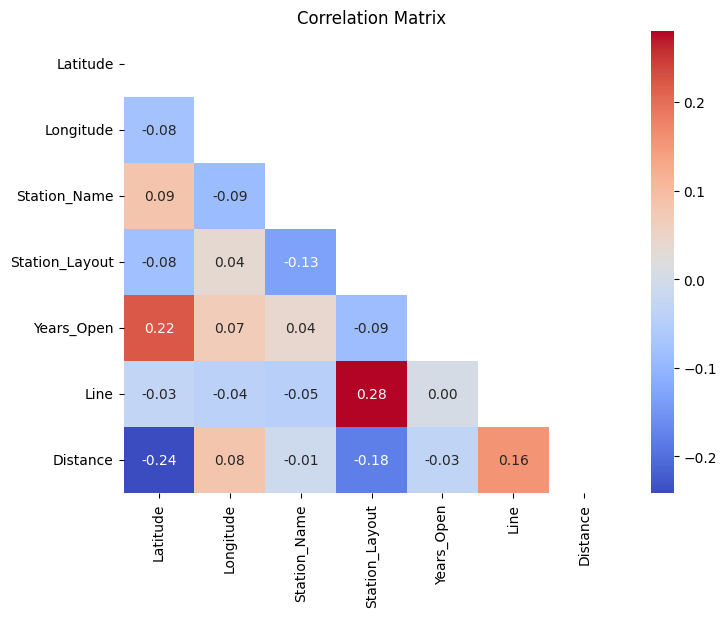

In [134]:
# Creating an object of LabelEncoder to use it's methods for categorizing numerical attributes of dataframe
label_encoder = LabelEncoder()

# Creating a copy of metro_data to not make changes to it's structure
metro_data_enc = metro_data.copy()

# Encoding the categorical variables: 'Station_Name', 'Station_Layout' & 'Line'
metro_data_enc['Station_Name'] = label_encoder.fit_transform(metro_data_enc['Station_Name'])
metro_data_enc['Station_Layout'] = label_encoder.fit_transform(metro_data_enc['Station_Layout'])
metro_data_enc['Line'] = label_encoder.fit_transform(metro_data_enc['Line'])

# Creating the correlation matrix
corr_matrix = metro_data_enc.corr()

# Creating a map to filter the top triangle since the correlation matrix is symmetrical
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plotting the Heatmap
plt.figure(figsize=(8,6)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",mask=mask)
plt.title('Correlation Matrix')
plt.show()  


The highest correlation found is betwen Station Layout & Line with a +0.28 correlation.

There is also some higher correlations of Latitude with Years open & Distance.
- If Longitude would also have these correlations with years & distance  I would suggest that there is some type of relationship/dependence
of the station location with the distance & years ,but in this case I can not come to that conclusion. 

Other correlations are really close to 0, which means that there is no significant relationship/correlation between attributes of the dataset.


**3.2 Visualizing the Number of Stations by number the number of years they have been opened for**

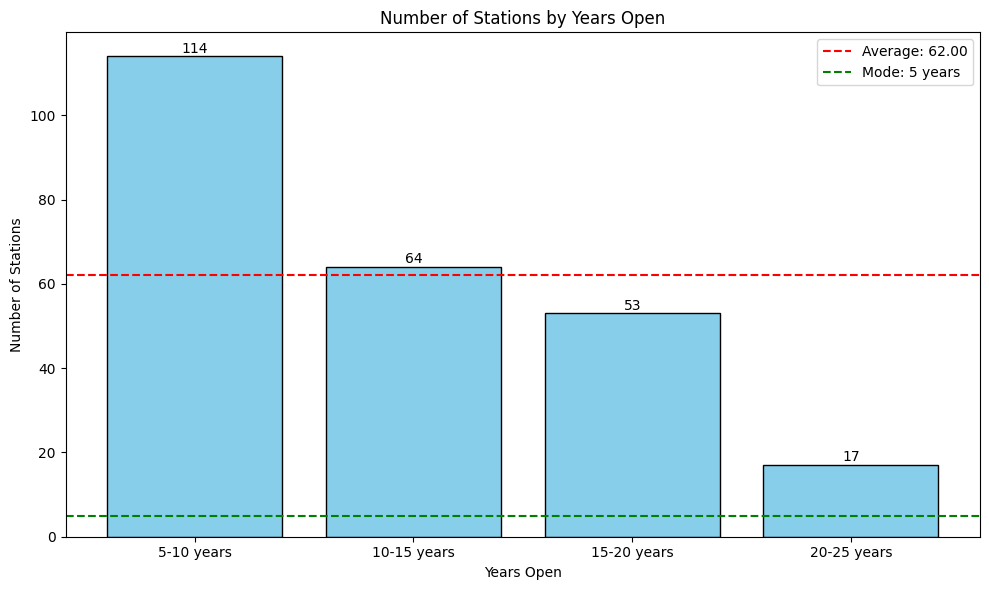

In [135]:
station_names = metro_data['Station_Name']
years_open = metro_data['Years_Open']

# Splitting 'Years_Open' in bins for better visualization purposes
duration_bins = [5, 10, 15, 20, 25] 
station_counts = [0] * (len(duration_bins) - 1)

# Updating station_counts
for duration in years_open:
    for i, bin in enumerate(duration_bins[:-1]):
        if duration >= bin and duration < duration_bins[i+1]:
            station_counts[i] += 1
            break

# Calculating average and mode
average = np.mean(station_counts)
mode = duration_bins[np.argmax(station_counts)]

# Creating the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar([f'{bin}-{bin+5} years' for bin in duration_bins[:-1]], station_counts, color='skyblue', edgecolor='black')
plt.xlabel('Years Open')
plt.ylabel('Number of Stations')
plt.title('Number of Stations by Years Open')
plt.tight_layout()

# Adding text annotations on top of the bars
for bar, count in zip(bars, station_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, str(count),
             ha='center', va='bottom')

# Adding annotations for average and mode
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')
plt.axhline(y=mode, color='g', linestyle='--', label=f'Mode: {mode} years')
plt.legend()

plt.show()

**3.2 Visualizing the Number of Stations by their Layout Type**

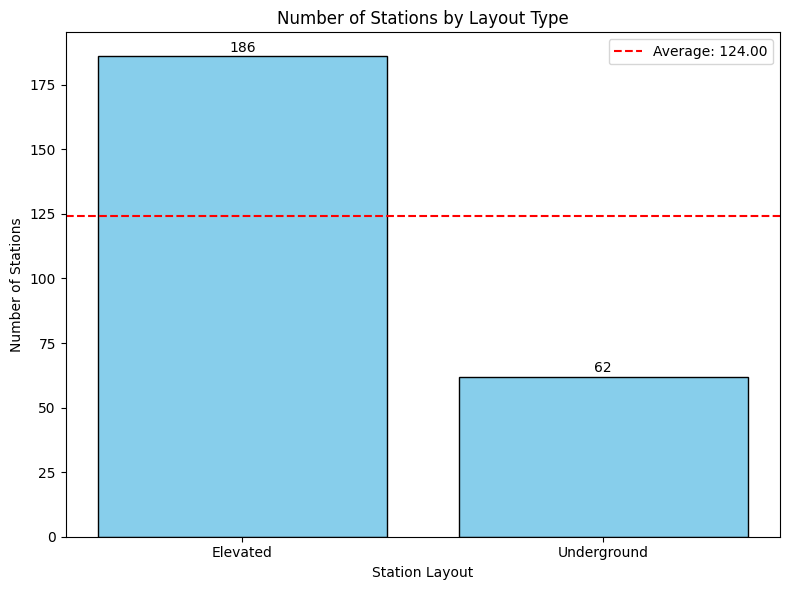

In [136]:
station_layouts = metro_data['Station_Layout']

# Counting the occurrences of each layout
layout_counts = {}
for layout in station_layouts:
    layout_counts[layout] = layout_counts.get(layout, 0) + 1

# Calculating average
average = np.mean(list(layout_counts.values()))

# Creating the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(layout_counts.keys(), layout_counts.values(), color='skyblue', edgecolor='black')
plt.xlabel('Station Layout')
plt.ylabel('Number of Stations')
plt.title('Number of Stations by Layout Type')

# Adding text annotations on top of the bars
for bar, count in zip(bars, layout_counts.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(count),
             ha='center', va='bottom')

# Adding annotations for average
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

**3.3 Visualizing dhe Count of Stations by Line Color**

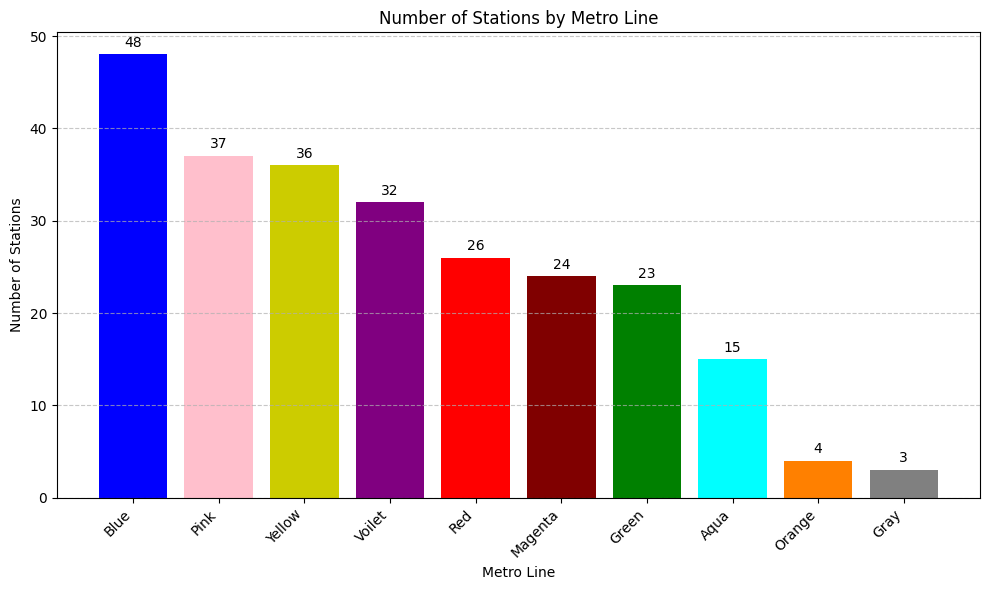

In [137]:
# Defining an array of lines and their corresponding colors in RGB
rbg_line_colors = {
    'Red': (1, 0, 0),          
    'Blue': (0, 0, 1),          
    'Yellow': (0.8, 0.8, 0),    
    'Green': (0, 0.5, 0),      
    'Voilet': (0.5, 0, 0.5),    
    'Pink': (1, 0.75, 0.8),     
    'Magenta': (0.5, 0, 0),     
    'Orange': (1, 0.5, 0),      
    'Aqua': (0, 1, 1),          
    'Gray': (0.5, 0.5, 0.5)     
}

metro_lines = metro_data['Line']
line_counts = metro_lines.value_counts().to_dict()

# Sorting the metro lines and line counts to display them in descending order
sorted_line_counts = dict(sorted(line_counts.items(), key=lambda x: x[1], reverse=True))

# Creating the bar plot
plt.figure(figsize=(10, 6))

# Giving the bars the colors corresponding to the metro lines
bars = plt.bar(sorted_line_counts.keys(), sorted_line_counts.values(),
               color=[rbg_line_colors[line] for line in sorted_line_counts.keys()])

# Adding text annotations on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(int(bar.get_height())),
             ha='center', va='bottom')

plt.xlabel('Metro Line')
plt.ylabel('Number of Stations')
plt.title('Number of Stations by Metro Line')
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

**3.4 Examining and Vizualising characteristics of Metro Lines - Number of Stations & Average Distance between Stations in km**

In [138]:
stations_per_line = metro_data['Line'].value_counts()

# Calculating the total distance of each metro line (max distance from start)
total_distance_per_line = metro_data.groupby('Line')['Distance'].max()

avg_distance_per_line = (total_distance_per_line / (stations_per_line - 1)).round(2)

line_analysis = pd.DataFrame({
    'Line': stations_per_line.index,
    'Number of Stations': stations_per_line.values,
    'Average Distance Between Stations (km)': avg_distance_per_line
})

# Sorting the dataframe by the number of stations
line_analysis = line_analysis.sort_values(by='Number of Stations', ascending=False)

line_analysis.reset_index(drop=True, inplace=True)
line_analysis

,Line,Number of Stations,Average Distance Between Stations (km)
0,Blue,48,1.78
1,Pink,37,1.00
2,Yellow,36,10.10
3,Voilet,32,1.13
4,Red,26,1.44
5,Magenta,24,5.97
6,Green,23,1.46
7,Aqua,15,1.31
8,Orange,4,1.40
9,Gray,3,1.31


In [139]:
# Creating an interactive horizontal bar plot with tooltips using plotly library
fig = px.bar(line_analysis, x='Number of Stations', y='Line',
             hover_data={'Number of Stations': True, 'Average Distance Between Stations (km)': True},
             color='Line', color_continuous_scale=rbg_line_colors,
             labels={'Number of Stations': 'Count of Line', 'Average Distance Between Stations (km)': 'Distance (km)', 'Line': 'Metro Line'},
             title='Metro Lines Analysis Chart',
             orientation='h')

fig.show()

**3.5 Maping the stations to visualize the coverage and distribution of the metro network across Delhi**

In [140]:
# Defining an array of lines and their corresponding colors
line_colors = {
    'Red': 'red',         
    'Blue': 'blue',       
    'Yellow': 'lightgreen',  #used lightgreen beacuse folium library had no 'yellow' color
    'Green': 'green',      
    'Voilet': 'purple',   
    'Pink': 'pink',   
    'Magenta': 'darkred',    
    'Orange': 'orange',  
    'Aqua': 'lightblue',  
    'Gray': 'gray'   
}

# Creating the map
delhi_map_with_line_tooltip = folium.Map(location=[28.7041, 77.1025], zoom_start=11)

# Adding colored markers for each metro station with station name, line color and station layout in the tooltip
for index, row in metro_data.iterrows():
    line = row['Line']
    station_name = row['Station_Name']
    station_layout = row['Station_Layout']
    color = line_colors.get(line, (0, 0, 0)) 
    tooltip_content = f"<b>Station Name</b>: {station_name}<br><b>Line</b>: {line}<br><b>Layout</b>: {station_layout}"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Station_Name']}",
        tooltip=tooltip_content,
        icon=folium.Icon(color=color)
    ).add_to(delhi_map_with_line_tooltip)

# Displaying the map
delhi_map_with_line_tooltip

End of **data_processing.ipynb.**

- For inserting the data into sql go to  **"sql\sql_insertion.ipynb"**

- For conditional formatting go to  **"excel\excel_writer.ipynb"**

- To see finished processed data go to **"preprocessed_data\Delhi-Metro-Network.csv"**

- To see formatted excel file go to **"excel\Delhi-Metro-Network-Formatted.csv"**
